In [65]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph

%matplotlib inline


## Building the Value Class

In [70]:
class Value: 
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op


    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def __neg__(self): 
        return self * -1
    
    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward(): 
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self): 
        x = self.data 
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward(): 
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self): 

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Go one variable at a time and apply the chain rule
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format=format, 
                  graph_attr={
                      'rankdir': rankdir,
                      'bgcolor': '#ffffff',  # White background
                      'ratio': 'expand',
                      'width': '100',
                      'height': '50',
                      'margin': '0.1',
                      'nodesep': '0.5',     # Increased space between nodes
                      'ranksep': '0.5'      # Increased rank separation
                  })
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        
        # Get the variable name if it exists in locals/globals
        var_name = None
        for name, value in globals().items():
            if value is n:
                var_name = name
                break
        if var_name is None:
            for name, value in locals().items():
                if value is n:
                    var_name = name
                    break
        
        # Enhanced node formatting
        label = f"""{{
            {var_name if var_name else ''}
            |data: {n.data:.4f}
            |grad: {n.grad:.4f}
        }}"""
        
        dot.node(name=uid, 
                label=label, 
                shape='record',
                style='filled',
                fillcolor='#e8f3ff',  # Light blue background
                color='#2878b5',      # Darker blue border
                fontname='Arial',
                fontsize='12')
        
        if n._op:
            # Operation node styling
            dot.node(name=uid + n._op, 
                    label=n._op,
                    shape='circle',
                    style='filled',
                    fillcolor='#ff9999',  # Light red for operations
                    color='#cc4444',      # Darker red border
                    fontname='Arial Bold',
                    fontsize='12',
                    width='0.5',
                    height='0.5')
            dot.edge(uid + n._op, uid, color='#666666')
    
    # Edge styling
    for n1, n2 in edges:
        dot.edge(str(id(n1)), 
                str(id(n2)) + n2._op, 
                color='#666666',
                penwidth='1.5')
    
    return dot


In [74]:
a = Value(2.0)
b = Value(3.0)

c = b + a
print(f"c.data: {c.data}")  # Should be 5.0

d = c ** 2
print(f"d.data: {d.data}")  # Should be 25.0

e = d * 2
print(f"e.data: {e.data}")  # Should be 50.0

f = e**2 + 5 

print(f"f.data: {f.data}")  # Should be 25005

g = f * f 

print(f"g.data: {g.data}")  # Should be 65025

h = g * 2 - 3

print(f"h.data: {h.data}")  # Should be 4228250622

h.backward()

print("\nGradients:")
print(f"h.grad: {h.grad}")
print(f"g.grad: {g.grad}")
print(f"f.grad: {f.grad}")
print(f"e.grad: {e.grad}")
print(f"d.grad: {d.grad}")
print(f"c.grad: {c.grad}")
print(f"b.grad: {b.grad}")
print(f"a.grad: {a.grad}")

c.data: 5.0
d.data: 25.0
e.data: 50.0
f.data: 2505.0
g.data: 6275025.0
h.data: 12550047.0

Gradients:
h.grad: 1.0
g.grad: 2.0
f.grad: 10020.0
e.grad: 1002000.0
d.grad: 2004000.0
c.grad: 20040000.0
b.grad: 20040000.0
a.grad: 20040000.0


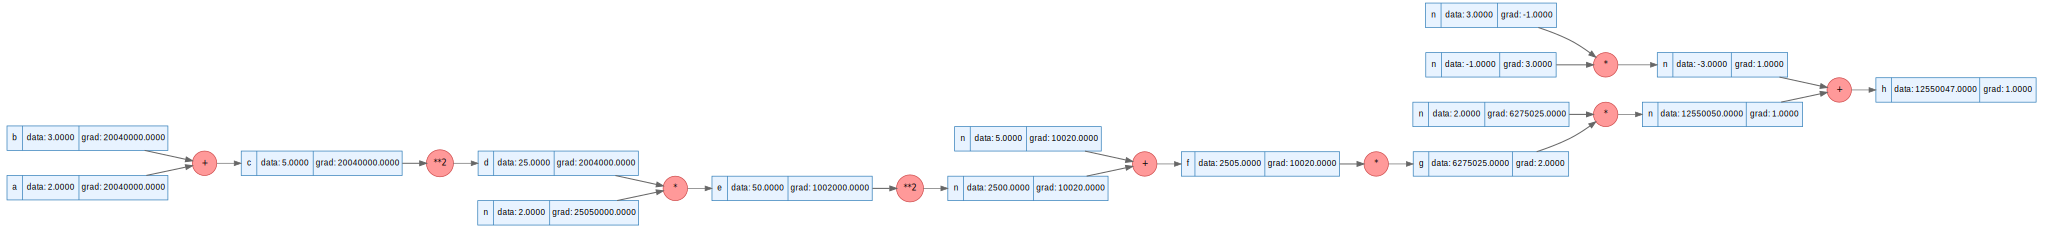

In [75]:
draw_dot(h)